# Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from collections import defaultdict

import textwrap
import json

from typing import List, Dict, Tuple, Any
from math import prod
from scipy.stats import pointbiserialr
from sklearn.preprocessing import MinMaxScaler

# Load Trainset and Testset

In [2]:
train_set_path = "../data/train.jsonl"
test_set_path = "../data/test.jsonl"

df_train = pd.read_json(train_set_path, lines=True)
df_test = pd.read_json(test_set_path, lines=True)

X = df_train.drop(columns=['player_won'])
Y = df_train['player_won']
X.head()

,p1_team_details,p2_lead_details,battle_timeline,battle_id
0,"[{'name': 'starmie', 'level': 100, 'types': ['...","{'name': 'starmie', 'level': 100, 'types': ['p...","[{'turn': 1, 'p1_pokemon_state': {'name': 'sta...",0
1,"[{'name': 'jynx', 'level': 100, 'types': ['ice...","{'name': 'alakazam', 'level': 100, 'types': ['...","[{'turn': 1, 'p1_pokemon_state': {'name': 'jyn...",1
2,"[{'name': 'exeggutor', 'level': 100, 'types': ...","{'name': 'chansey', 'level': 100, 'types': ['n...","[{'turn': 1, 'p1_pokemon_state': {'name': 'exe...",2
3,"[{'name': 'gengar', 'level': 100, 'types': ['g...","{'name': 'tauros', 'level': 100, 'types': ['no...","[{'turn': 1, 'p1_pokemon_state': {'name': 'gen...",3
4,"[{'name': 'alakazam', 'level': 100, 'types': [...","{'name': 'starmie', 'level': 100, 'types': ['p...","[{'turn': 1, 'p1_pokemon_state': {'name': 'ala...",4


# Tabella Moltiplicatore Tipi

In [3]:
effectiveness = {
    "normal":    {"rock": 0.5, "ghost": 0, "steel": 0.5},
    "fire":      {"fire": 0.5, "water": 0.5, "grass": 2, "ice": 2, "bug": 2, "rock": 0.5, "dragon": 0.5, "steel": 2},
    "water":     {"fire": 2, "water": 0.5, "grass": 0.5, "ground": 2, "rock": 2, "dragon": 0.5},
    "electric":  {"water": 2, "electric": 0.5, "grass": 0.5, "ground": 0, "flying": 2, "dragon": 0.5},
    "grass":     {"fire": 0.5, "water": 2, "grass": 0.5, "poison": 0.5, "ground": 2, "flying": 0.5, "bug": 0.5, "rock": 2, "dragon": 0.5, "steel": 0.5},
    "ice":       {"fire": 0.5, "water": 0.5, "grass": 2, "ground": 2, "flying": 2, "dragon": 2, "steel": 0.5},
    "fighting":  {"normal": 2, "ice": 2, "poison": 0.5, "flying": 0.5, "psychic": 0.5, "bug": 0.5, "rock": 2, "ghost": 0, "dark": 2, "steel": 2},
    "poison":    {"grass": 2, "poison": 0.5, "ground": 0.5, "rock": 0.5, "ghost": 0.5, "steel": 0},
    "ground":    {"fire": 2, "electric": 2, "grass": 0.5, "poison": 2, "flying": 0, "bug": 0.5, "rock": 2, "steel": 2},
    "flying":    {"electric": 0.5, "grass": 2, "fighting": 2, "bug": 2, "rock": 0.5, "steel": 0.5},
    "psychic":   {"fighting": 2, "poison": 2, "psychic": 0.5, "dark": 0, "steel": 0.5},
    "bug":       {"fire": 0.5, "grass": 2, "fighting": 0.5, "poison": 0.5, "flying": 0.5, "psychic": 2, "ghost": 0.5, "dark": 2, "steel": 0.5},
    "rock":      {"fire": 2, "ice": 2, "fighting": 0.5, "ground": 0.5, "flying": 2, "bug": 2, "steel": 0.5},
    "ghost":     {"normal": 0, "psychic": 2, "ghost": 2, "dark": 0.5},
    "dragon":    {"dragon": 2, "steel": 0.5},
    "dark":      {"fighting": 0.5, "psychic": 2, "ghost": 2, "dark": 0.5, "steel": 0.5},
    "steel":     {"fire": 0.5, "water": 0.5, "electric": 0.5, "ice": 2, "rock": 2, "steel": 0.5}
}


# Pokemons


In [4]:
pokemons ={'starmie': ['psychic', 'water'], 'exeggutor': ['grass', 'psychic'], 'chansey': ['normal', 'notype'],
    'snorlax': ['normal', 'notype'], 'tauros': ['normal', 'notype'], 'alakazam': ['notype', 'psychic'], 
    'jynx': ['ice', 'psychic'], 'slowbro': ['psychic', 'water'], 'gengar': ['ghost', 'poison'], 
    'rhydon': ['ground', 'rock'], 'zapdos': ['electric', 'flying'], 'cloyster': ['ice', 'water'], 'golem': ['ground', 'rock'], 
    'jolteon': ['electric', 'notype'], 'articuno': ['flying', 'ice'], 'persian': ['normal', 'notype'], 
    'lapras': ['ice', 'water'], 'dragonite': ['dragon', 'flying'], 'charizard': ['fire', 'flying'], 'victreebel': ['grass', 'poison']}


In [5]:
stats_pokemons = {
    pokemon['name']: {'hp' : pokemon['base_hp'],
                     'attack' : pokemon['base_atk'],
                     'defense' : pokemon['base_def'],
                     'sp_attack' : pokemon['base_spa'],
                     'sp_defense' : pokemon['base_spd'],
                     'speed' : pokemon['base_spe']}
    for team in X['p1_team_details']
    for pokemon in team
}
stats_df = pd.DataFrame.from_dict(stats_pokemons, orient='index')

stats_df.index.name = 'Pokemon'
stats_df['Total'] = stats_df.sum(axis=1)
stats_df

,hp,attack,defense,sp_attack,sp_defense,speed,Total
Pokemon,,,,,,,
starmie,60,75,85,100,100,115,535
exeggutor,95,95,85,125,125,55,580
chansey,250,5,5,105,105,50,520
snorlax,160,110,65,65,65,30,495
tauros,75,100,95,70,70,110,520
alakazam,55,50,45,135,135,120,540
jynx,65,50,35,95,95,95,435
slowbro,95,75,110,80,80,30,470
gengar,60,65,60,130,130,110,555


# Stab and Effectiveness
In Pokémon, moves can be super effective, not very effective, or ineffective, depending on the type matchup. This mechanic is known as type effectiveness.

With this function, we calculate two ratios for each battle:

The effectiveness ratio, which measures how often effective moves are used during the match.

The STAB ratio (Same-Type Attack Bonus), which indicates how frequently a Pokémon uses moves that match its own type in which case the move’s base power is multiplied by 1.5.

And we aggregate them giving a different weight to each one

In [6]:
def extract_effectiveness_stab_features(battle_timeline):
    """Restituisce effectiveness_ratio, stab_ratio e una feature aggregata."""
    p1_effectiveness = []
    p2_effectiveness = []
    p1_stabs = []
    p2_stabs = []

    for turn in battle_timeline:
        for prefix_att, prefix_def in [('p1', 'p2'), ('p2', 'p1')]:
            move = turn.get(f'{prefix_att}_move_details')
            state_att = turn.get(f'{prefix_att}_pokemon_state')
            state_def = turn.get(f'{prefix_def}_pokemon_state')

            if not move or move.get('category') not in ['PHYSICAL', 'SPECIAL']:
                continue

            attacker = state_att.get('name')
            defender = state_def.get('name')

            attacker_types = pokemons.get(attacker, [])
            move_type = move.get('type', '').lower()
            stab = 1.5 if move_type in attacker_types else 1.0

            effective = 1.0
            for typ in pokemons.get(defender, []):
                if move_type in effectiveness and typ in effectiveness[move_type]:
                    effective *= effectiveness[move_type][typ]

            if prefix_att == 'p1':
                p1_effectiveness.append(effective)
                p1_stabs.append(stab)
            else:
                p2_effectiveness.append(effective)
                p2_stabs.append(stab)

    mean_eff_p1 = np.mean(p1_effectiveness) if p1_effectiveness else 1.0
    mean_eff_p2 = np.mean(p2_effectiveness) if p2_effectiveness else 1.0
    effectiveness_ratio = mean_eff_p1 / mean_eff_p2 if mean_eff_p2 != 0 else mean_eff_p1

    stab_rate_p1 = np.mean([1 if s == 1.5 else 0 for s in p1_stabs]) if p1_stabs else 0
    stab_rate_p2 = np.mean([1 if s == 1.5 else 0 for s in p2_stabs]) if p2_stabs else 0
    stab_ratio = stab_rate_p1 / stab_rate_p2 if stab_rate_p2 != 0 else stab_rate_p1

    agg_feature = 0.9 * effectiveness_ratio + 0.1 * stab_ratio

    return agg_feature


X['agg_effectiveness_stab'] =  X['battle_timeline'].apply(extract_effectiveness_stab_features)


# Hp

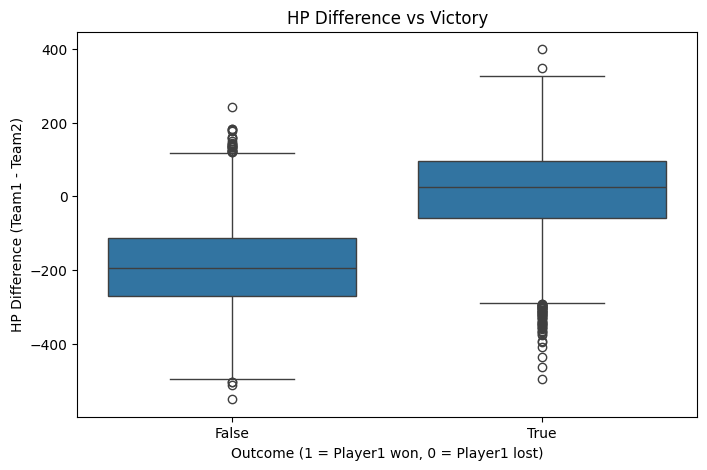

In [7]:
def hp_features(battle_timeline):
    """
    Calculates the total HP difference (Team 1 - Team 2) at the end of the battle.

    This is based on the last recorded HP percentage for each Pokemon in the 
    battle_timeline, assuming a total of 600 HP (6x100) per team.
    """
    team1 = {}
    team2 = {}
    for turn in battle_timeline:
        team1[turn['p1_pokemon_state']['name']] = turn['p1_pokemon_state']['hp_pct']
        team2[turn['p2_pokemon_state']['name']] = turn['p2_pokemon_state']['hp_pct']

    team1_hp = 600 - sum((1 - hp) * 100 for hp in team1.values())
    team2_hp = 600 - sum((1 - hp) * 100 for hp in team2.values())
    
    hp_diff = team1_hp - team2_hp

    return hp_diff

X['hp_diff'] = pd.DataFrame(
    [hp_features(timeline) for timeline in X['battle_timeline']]
)

plt.figure(figsize=(8,5))
sns.boxplot(x=Y, y=X['hp_diff'])
plt.xlabel('Outcome (1 = Player1 won, 0 = Player1 lost)')
plt.ylabel('HP Difference (Team1 - Team2)')
plt.title('HP Difference vs Victory')
plt.show()

# Status


In [8]:
def status_features(battle_timeline, num_turns=30):
    """
    Calculates the difference in status condition proportions over the battle.

    It tracks the proportion of turns that P1 and P2 spent 
    afflicted with 'par', 'frz', 'fnt', or 'slp'. 

    Returns a difference vector [par, frz, fnt, slp, nostatus], where
    a positive value favors Player 1 (P2_prop - P1_prop).
    """
    
    all_status = ["par", "frz", "fnt", "slp", "nostatus"]
    
    status_1 = {s: 0 for s in all_status}
    status_2 = {s: 0 for s in all_status}
    
    for turn in battle_timeline:
        s1 = turn["p1_pokemon_state"].get('status')
        s2 = turn["p2_pokemon_state"].get('status')
        if s1 in all_status:
            status_1[s1] += 1
        if s2 in all_status:
            status_2[s2] += 1
            
    prop_1 = {s: status_1[s] / num_turns for s in all_status}
    prop_2 = {s: status_2[s] / num_turns for s in all_status}
    
    diff_vector = []
    for s in all_status:
            diff_vector.append(prop_2[s] - prop_1[s])
    
    return diff_vector

status_cols = ['diff_par', 'diff_frz', 'diff_fnt', 'diff_slp', 'diff_nostatus']

status_data_series = X['status_diff_vector'] = X['battle_timeline'].apply(lambda x: status_features(x, num_turns=30))
status_df = pd.DataFrame(
    status_data_series.tolist(), 
    columns=status_cols, 
    index=X.index
)
X = X.drop(columns='status_diff_vector')
X = X.join(status_df)

# None Moves

In [9]:
def none_features(battle_timeline: List[Dict[str, Any]]) -> float:
    """
    Calcola la differenza nella percentuale di turni senza mosse tra p2 e p1.
    
    Un valore > 0 significa che p2 ha avuto una percentuale maggiore di
    turni "None" rispetto a p1.
    """
    p1_none_count = 0
    p2_none_count = 0
    
    for turn in battle_timeline:
        if not turn.get('p1_move_details'):
            p1_none_count += 1
        if not turn.get('p2_move_details'):
            p2_none_count += 1
            
    p1_none_rate = p1_none_count / 30
    p2_none_rate = p2_none_count / 30
    
    
    return p1_none_rate, p2_none_rate

risultati_df = pd.DataFrame(
    X['battle_timeline'].apply(none_features).tolist(),
    columns=['p1_none_rate', 'p2_none_rate'],
    index=X.index  
)
X = pd.concat([X, risultati_df], axis=1)

# Move Damage and Accuracy

In [10]:
def compute_move_features(battle_timeline: List[Dict[str, Any]]) -> Dict[str, float]:
    """
    Calculates mean move power and accuracy for p1 and p2,
    plus the differences between them (p1 - p2).

    'None' moves (no move details) are treated as having 0 power
    and 0 accuracy in the mean calculation.
    """

    stats = {"p1": {"base_power": [], "accuracy": []},
             "p2": {"base_power": [], "accuracy": []}}

    for turn in battle_timeline:
        for pid in ["p1", "p2"]:
            move = turn.get(f"{pid}_move_details")
            if move:
                stats[pid]["base_power"].append(move.get("base_power", 0) or 0)
                stats[pid]["accuracy"].append(move.get("accuracy", 0) or 0)
            else:
                stats[pid]["base_power"].append(0)
                stats[pid]["accuracy"].append(0)

    features = {}
    for pid in ["p1", "p2"]:
        bp = np.array(stats[pid]["base_power"], dtype=float)
        acc = np.array(stats[pid]["accuracy"], dtype=float)

        features[f"{pid}_mean_power"] = bp.mean()
        features[f"{pid}_mean_acc"] = acc.mean()

    features["diff_mean_power"] = (features["p1_mean_power"] - features["p2_mean_power"]) / 100.0
    features["diff_mean_acc"] = features["p1_mean_acc"] - features["p2_mean_acc"]
    return features

move_features_df = X["battle_timeline"].apply(compute_move_features).apply(pd.Series)
X = pd.concat([X, move_features_df], axis=1)


# Lead Score 

In [11]:
def best_effectiveness(attacker_types, defender_types):
    best = 0
    for atk_type in attacker_types:
        if atk_type not in effectiveness:
            continue
        eff = np.prod([
            effectiveness[atk_type].get(def_type, 1.0)
            for def_type in defender_types
        ])
        best = max(best, eff)
    return best

In [12]:
def get_lead_advantage_feature(p1_lead_name, p2_lead_name) -> float:
    """
    Ritorna un singolo punteggio numerico che rappresenta il vantaggio
    di P1 sul lead di P2.
    
    Usa il dizionario 'effectiveness' definito globalmente.

    - Punteggio > 0: Vantaggio P1
    - Punteggio < 0: Vantaggio P2
    """

    p1_stats = stats_pokemons[p1_lead_name]
    p2_stats = stats_pokemons[p2_lead_name]

    p1_types_raw = pokemons[p1_lead_name]
    p1_types = [str(t).lower() for t in p1_types_raw if pd.notna(t) and str(t).lower() != 'notype']
    p2_types_raw = pokemons[p2_lead_name]
    p2_types = [str(t).lower() for t in p2_types_raw if pd.notna(t) and str(t).lower() != 'notype']
    p1_best_stab_eff = best_effectiveness(p1_types, p2_types)
    p2_best_stab_eff = best_effectiveness(p2_types, p1_types)
    type_score = (p1_best_stab_eff - p2_best_stab_eff) / 4
    speed_score = (p1_stats['speed'] - p2_stats['speed']) / 100.0
    final_score = 0.5 * type_score + 0.5 * speed_score
    
    return final_score

X['lead_advantage_score'] = X.apply(
    lambda row: get_lead_advantage_feature(
        row['p1_team_details'][0]['name'],  
        row['p2_lead_details']['name'],     
    ),
    axis=1
)



# Team Comp


In [13]:
def create_team_strength_mapping(X_data, y_data, k=20):
    """
    Crea una mappa di "forza del team" basata sui tipi, calcolata 
    sui dati di addestramento.
    
    Args:
        X_data (pd.DataFrame): DataFrame di addestramento (contenente 'p1_team_details').
        y_data (pd.Series): Serie di etichette (target) di addestramento.
        k (int): Fattore di smoothing Bayesiano.

    Returns:
        dict: Un dizionario contenente la mappa ('map'), lo scaler ('scaler')
              e il valore di default ('default_val') per i team non visti.
    """
    team_results = defaultdict(list)
    for team, win in zip(X_data['p1_team_details'], y_data):
        squad = tuple(sorted(
            {ptype for pokemon in team for ptype in pokemon['types'] if ptype != "notype"}
        ))
        team_results[squad].append(win)

    team_winrate = {team: sum(results)/len(results) 
                    for team, results in team_results.items() if results}

    global_mean = np.mean(list(team_winrate.values()))
    
    team_strength = {
        team: (len(team_results[team]) / (len(team_results[team]) + k)) * winrate + 
              (k / (len(team_results[team]) + k)) * global_mean
        for team, winrate in team_winrate.items()
    }

    scaler = MinMaxScaler()
    strength_values = np.array(list(team_strength.values())).reshape(-1, 1)
    normalized_strengths = scaler.fit_transform(strength_values).flatten()

    team_strength_norm = dict(zip(team_strength.keys(), normalized_strengths))
    
    default_val_normalized = scaler.transform(np.array([[global_mean]]))[0][0]

    return {
        'map': team_strength_norm, 
        'scaler': scaler,
        'default_val': default_val_normalized 
    }

In [14]:
mapping = create_team_strength_mapping(X,Y)
X['team_strength'] = X['p1_team_details'].apply(
    lambda team: mapping['map'].get(
        tuple(sorted(
            {ptype for pokemon in team for ptype in pokemon['types'] if ptype != "notype"}
        )),
        mapping['default_val']
    )
)


# Coverage


In [15]:
def compute_team_coverage(pokemon_details):
    """
    Calcola una feature di sinergia/coverage del team in base ai tipi.
    Restituisce un valore continuo tra -1 e +1 (più alto = team più bilanciato).
    """
    all_types = list(effectiveness.keys())
    team_types = []
    for p in pokemon_details:
        name = p.get('name')
        if name in pokemons:
            team_types.extend(pokemons[name])
    team_types = list(set(team_types))  

    if not team_types:
        return 0.0  

    coverage_score = 0
    weakness_score = 0

    for target_type in all_types:
        max_eff = 1.0
        for team_type in team_types:
            if team_type in effectiveness and target_type in effectiveness[team_type]:
                max_eff = max(max_eff, effectiveness[team_type][target_type])

        max_weak = 1.0
        for team_type in team_types:
            if target_type in effectiveness and team_type in effectiveness[target_type]:
                max_weak = max(max_weak, effectiveness[target_type][team_type])

        if max_eff > 1:
            coverage_score += 1
        if max_weak > 1:
            weakness_score += 1

    total_types = len(all_types)
    team_coverage = (coverage_score - weakness_score) / total_types

    return round(team_coverage, 3)

X['p1_coverage'] = X['p1_team_details'].apply(compute_team_coverage)

scaler = MinMaxScaler()
X[['p1_coverage']] = scaler.fit_transform(X[['p1_coverage']])

X['p1_coverage'].corr(Y)

np.float64(-0.042741994414194524)

# Superefficaci Non Efficaci

In [16]:
def move_effectiveness_feature(
    battle_timeline: List[Dict[str, Any]], 
    pokemons_data: Dict[str, List[str]],
    effectiveness_data: Dict
) -> Dict[str, float]:
    """
    Analyzes a battle timeline to calculate the aggregated fraction of "good"
    (x1, x2, x4) and "bad" (x0, x0.25, x0.5) offensive moves for each player.
    """
    multipliers_map = {0: 'x0', 0.25: 'x0_25', 0.5: 'x0_5', 1.0: 'x1', 2: 'x2', 4: 'x4'}
    counts = {}
    total_offensive_moves = {'p1': 0, 'p2': 0}

    for player in ['p1', 'p2']:
        for key_suffix in multipliers_map.values():
            counts[f'{player}_{key_suffix}_moves'] = 0

    for turn in battle_timeline:
        player_map = {'p1': 'p2', 'p2': 'p1'}
        for attacker, defender in player_map.items():
            move = turn.get(f'{attacker}_move_details')
            
            if not move or move.get('category') not in ['PHYSICAL', 'SPECIAL']:
                continue

            total_offensive_moves[attacker] += 1
            attack_type = move.get('type').lower()
            defending_pokemon_state = turn.get(f'{defender}_pokemon_state', {})
            defending_pokemon_name = defending_pokemon_state.get('name')
            
            if not defending_pokemon_name:
                continue 

            defending_types_raw = pokemons_data.get(defending_pokemon_name, [])
            defending_types = [t for t in defending_types_raw if t != 'notype']
            
            total_multiplier = 1.0
            if defending_types:
                total_multiplier = prod(
                    effectiveness_data.get(attack_type, {}).get(def_type, 1.0)
                    for def_type in defending_types
                )
            
            if total_multiplier in multipliers_map:
                key_suffix = multipliers_map[total_multiplier]
                counts[f'{attacker}_{key_suffix}_moves'] += 1
    
    normalized_features = {}
    for player in ['p1', 'p2']:
        total_moves = total_offensive_moves[player]
        for key_suffix in multipliers_map.values():
            feature_name = f'{player}_{key_suffix}_moves'
            
            if total_moves > 0:
                normalized_features[feature_name] = counts[feature_name] / total_moves
            else:
                normalized_features[feature_name] = 0.0

    final_aggregated_features = {}
    for player in ['p1', 'p2']:
        final_aggregated_features[f'{player}_good_moves'] = (
            normalized_features[f'{player}_x1_moves'] +
            normalized_features[f'{player}_x2_moves'] +
            normalized_features[f'{player}_x4_moves']
        )
        final_aggregated_features[f'{player}_bad_moves'] = (
            normalized_features[f'{player}_x0_moves'] +
            normalized_features[f'{player}_x0_25_moves'] +
            normalized_features[f'{player}_x0_5_moves']
        )

    return final_aggregated_features

features_series = X['battle_timeline'].apply(
    move_effectiveness_feature,
    pokemons_data=pokemons,
    effectiveness_data=effectiveness
)

features_df = pd.DataFrame(features_series.tolist(), index=X.index)
X = X.join(features_df)

# Boost

In [17]:
def boost_feature(
    battle_timeline: List[Dict[str, Any]]
) -> Dict[str, int]:
    """
    Calcola la somma cumulativa dei boost netti (atk+def+spa+spd+spe)
    per ogni giocatore, sommando il loro stato ad ogni turno della timeline.

    Ad esempio, un giocatore che è a +2 netto per 10 turni avrà un 
    punteggio finale di 20 (2 * 10).
    """
    p1_boosts = 0
    p2_boosts = 0 
    for turn in battle_timeline:
        p1_state = turn.get('p1_pokemon_state')
        p2_state = turn.get('p2_pokemon_state', {})

        p1_boosts += sum(p1_state.get('boosts').values())
        p2_boosts += sum(p2_state.get('boosts').values())
    
    return {
        'p1_boost': p1_boosts/30,
        'p2_boost': p2_boosts/30,
        'diff_boost' : (p1_boosts - p2_boosts)/30
    }


features_series = X['battle_timeline'].apply(boost_feature)
features_df = pd.DataFrame(features_series.tolist(), index=X.index)
X = X.join(features_df)


# Heatmap

In [11]:
X_clean = X.drop(columns=['p1_team_details', 'p2_lead_details', 'battle_timeline', 'battle_id'])
X_clean['label'] = Y

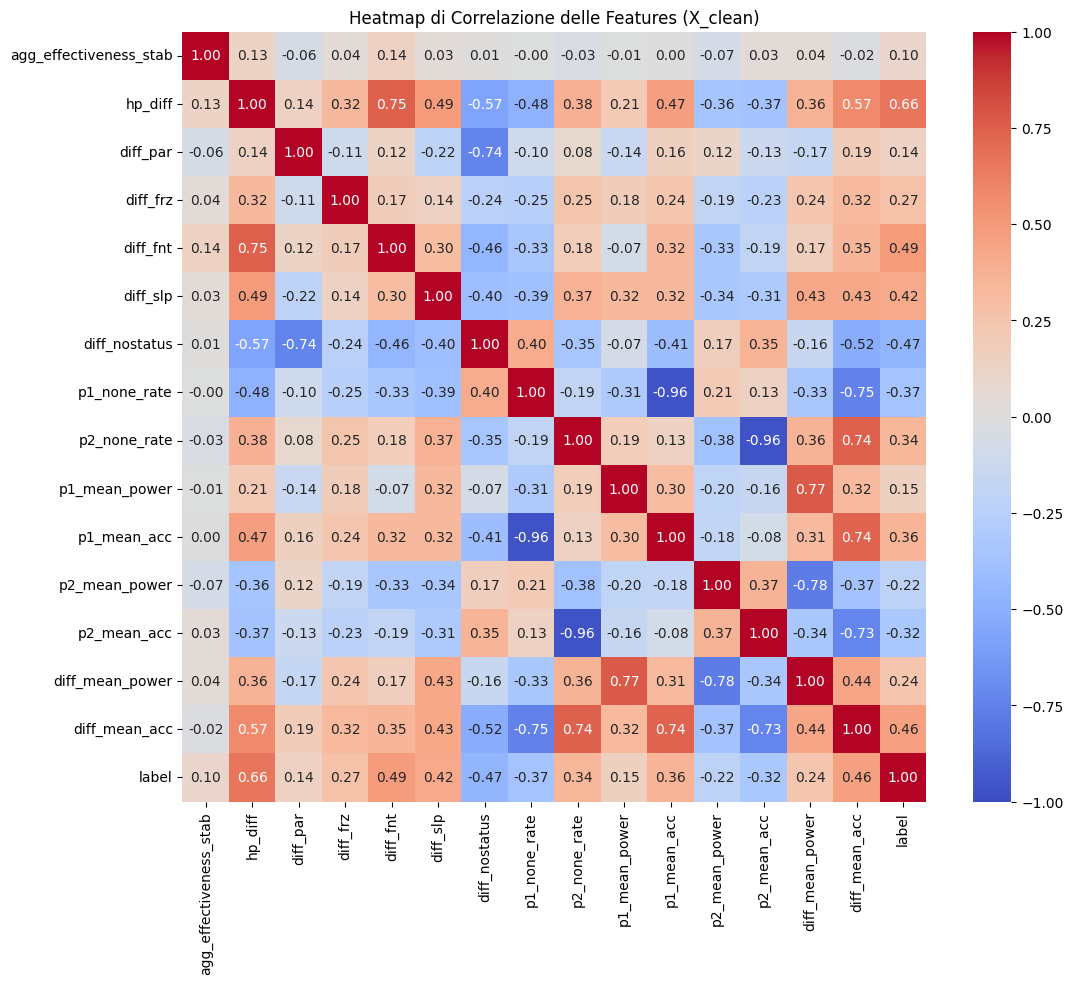

In [12]:
corr_matrix = X_clean.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,   
    annot=True,     
    fmt='.2f',      
    cmap='coolwarm',
    vmin=-1,        
    vmax=1          
)

plt.title('Heatmap di Correlazione delle Features (X_clean)')
plt.show()